In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import sparse
import requests
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer
import re
from IPython.display import display
from scipy.sparse.linalg import svds

### Part 0: Load Data

In [69]:
# Load df_books and genres
wd = os.getcwd()
df_books = pd.read_csv(wd + "/data/goodreads_books.csv")
df_inferred_genres = pd.read_csv(wd + "/data/inferred_genres.csv")

# Join genres to books
df_books = pd.merge(df_books, df_inferred_genres.drop(columns="title"), how="left", on="book_id")

In [70]:
# Load sparse_reviews from file
df_reviews = sparse.load_npz(wd + "/data/user_reviews.npz")

# Load user (rows) and book (cols) indices
user_index = pd.read_csv(wd + "/data/user_index_for_sparse_matrix.csv").rename(columns={"0":"user_id"})
book_index = pd.read_csv(wd + "/data/book_index_for_sparse_matrix.csv").rename(columns={"0":"book_id"})

In [71]:
# Load my goodreads history
my_books = pd.read_csv(wd + "/data/goodreads_library_export.csv")

# Filter to books I've rated
my_books = my_books[["Book Id", "My Rating"]].rename(columns={"Book Id":"book_id", "My Rating":"rating"}).query("rating > 0")

# Reformat to fit sparse matrix
my_books = pd.merge(book_index, my_books, how="left", on="book_id").fillna(0.)
my_books = np.array(my_books["rating"]).reshape(1,-1)

# Add to sparse matrix
df_reviews = sparse.vstack([df_reviews, my_books])

# # Replace 0 with 0.1 to prevent cosine similarities from zeroing
# sparse_fill = 0.001
# df_reviews.data[df_reviews.data == 0] = sparse_fill

### Part 1: Find Similar Users

In [72]:
# Normalize reviews within users
norm = Normalizer()
df_reviews = norm.fit_transform(df_reviews) 

In [73]:
target = df_reviews.shape[0] - 1

In [74]:
# Function to use KNN to find similar users
def find_neighbors(n_neighbors, target_user, ratings_df, ind_books, books):

    # Instantiate KNN
    n_neighbors = n_neighbors

    nn_model = NearestNeighbors(
        metric="cosine",
        algorithm="auto",
        n_neighbors=n_neighbors,
        n_jobs=-1
    )

    # Fit to sparse matrix
    nn_model.fit(ratings_df)

    # Feed in user and get neighbors and distances
    reader = ratings_df[target,:].toarray()
    dists, neighbors = nn_model.kneighbors(reader, return_distance=True)

    similar_users = pd.DataFrame(
        [pd.Series(neighbors.reshape(-1)), pd.Series(dists.reshape(-1))]).T.rename(columns={0:"user", 1:"distance"}
    )

    # Get all books read by similar users
    book_ind = []
    book_rat = []
    uid = []
    target_user_books = []
    target_user_book_rat = []
    for nt in similar_users.itertuples():
        user = ratings_df[int(nt.user),:].toarray()
        book_inds = np.where(user[0] > 0)[0]
        ratings = user[0][np.where(user[0] > 0)[0]]
        for i in range(len(book_inds)):        
            book_ind.append(book_inds[i])
            book_rat.append(ratings[i])
            uid.append(nt.user)    
            if nt.distance < 0.000000001:
                target_user_books.append(book_inds[i])
                target_user_book_rat.append(ratings[i])

    neighbor_user_ratings = pd.DataFrame([uid, book_ind, book_rat]).T.rename(columns={0:"uid",1:"book_index",2:"user_rating"})

    # Join overall rating for each book
    neighbor_user_ratings = pd.merge(ind_books.reset_index(), neighbor_user_ratings, how="inner", left_on="index", right_on="book_index")
    neighbor_user_ratings = pd.merge(neighbor_user_ratings, books, how="inner", on="book_id")

    # Filter out books target reader has already read
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["book_index"].isin(target_user_books)]
    neighbor_user_ratings.drop(["index"], axis=1, inplace=True)

    # Filter out later volumes in series using regex pattern
    regex1 = r"#([2-9]|[1-9]\d+)"
    regex2 = r"Vol. ([2-9]|[1-9]\d+)"
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]

    # View target user's ratings
    target_user_ratings = pd.DataFrame([target_user_books, target_user_book_rat]).T.rename(columns={0:"book_index",1:"user_rating"})
    target_user_ratings = pd.merge(ind_books.reset_index(), target_user_ratings, how="inner", left_on="index", right_on="book_index")
    target_user_ratings = pd.merge(target_user_ratings, books, how="inner", on="book_id")    

    return neighbor_user_ratings, target_user_ratings

In [75]:
neighbor_user_ratings, target_user_ratings = find_neighbors(75, target, df_reviews, book_index, df_books)

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_62901/1194291868.py:56: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_62901/1194291868.py:57: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]


In [76]:
# View neighbors rating table
neighbor_user_ratings.head()

,book_id,uid,book_index,user_rating,title,avg_rating,ratings_count,year,language_code,image_url,...,Genre_11,Genre_12,Genre_13,Genre_14,Genre_15,Genre_16,Genre_17,Genre_18,Genre_19,Genre_20
0,100915,83359.0,5497.0,0.267860,"The Lion, the Witch, and the Wardrobe (Chronic...",4.19,1575387.0,2005,eng,https://images.gr-assets.com/books/1353029077m...,...,0.009122,0.009122,0.009122,0.009122,0.009122,0.826681,0.009122,0.009122,0.009122,0.009122
1,10127019,149314.0,8108.0,0.114992,The Lean Startup: How Today's Entrepreneurs Us...,4.04,95622.0,2011,en-US,https://images.gr-assets.com/books/1333576876m...,...,0.006269,0.006269,0.006269,0.006269,0.006269,0.006269,0.006269,0.006269,0.006269,0.006269
2,10193060,122168.0,13183.0,0.248452,Miserere: An Autumn Tale,3.79,747.0,2011,eng,https://images.gr-assets.com/books/1301084223m...,...,0.007666,0.007666,0.007666,0.007666,0.007666,0.007666,0.854340,0.007666,0.007666,0.007666
3,10245518,133863.0,17082.0,0.158986,The Checklist Manifesto How to Get Things Right,4.03,268.0,2011,eng,https://images.gr-assets.com/books/1356488549m...,...,0.005871,0.005871,0.005871,0.005871,0.005871,0.005871,0.005871,0.005871,0.005871,0.005871
4,10321016,204297.0,22603.0,0.368230,Pitch Anything: An Innovative Method for Prese...,4.09,4346.0,2011,NaN,https://s.gr-assets.com/assets/nophoto/book/11...,...,0.007005,0.007005,0.007005,0.007005,0.007005,0.007005,0.007005,0.007005,0.007005,0.007005


In [77]:
# View target user's ratings
target_user_ratings.head(10)

,index,book_id,book_index,user_rating,title,avg_rating,ratings_count,year,language_code,image_url,...,Genre_11,Genre_12,Genre_13,Genre_14,Genre_15,Genre_16,Genre_17,Genre_18,Genre_19,Genre_20
0,159556,12352452,159556.0,0.084853,"Season of the Witch: Enchantment, Terror and D...",4.22,2481.0,2012,NaN,https://images.gr-assets.com/books/1329324459m...,...,0.004979,0.004979,0.004979,0.004979,0.004979,0.004979,0.004979,0.004979,0.004979,0.004979
1,222333,13166586,222333.0,0.084853,The Fish That Ate the Whale: The Life and Time...,3.97,1497.0,2012,eng,https://images.gr-assets.com/books/1327473440m...,...,0.005590,0.005590,0.005590,0.005590,0.005590,0.005590,0.005590,0.005590,0.005590,0.005590
2,270440,13554058,270440.0,0.084853,The Wandering Earth,4.01,894.0,2012,eng,https://images.gr-assets.com/books/1332444998m...,...,0.008574,0.008574,0.008574,0.008574,0.008574,0.342984,0.502676,0.008574,0.008574,0.008574
3,340694,15195,340694.0,0.113137,"The Complete Maus (Maus, #1-2)",4.53,79457.0,2003,en-GB,https://images.gr-assets.com/books/1327354180m...,...,0.008383,0.008383,0.008383,0.008383,0.008383,0.008383,0.008383,0.008383,0.008383,0.008383
4,442607,16256798,442607.0,0.056569,The One Thing: The Surprisingly Simple Truth B...,4.15,15237.0,2013,eng,https://images.gr-assets.com/books/1362177469m...,...,0.011160,0.011160,0.011160,0.011160,0.011160,0.011160,0.011160,0.011160,0.011160,0.011160
5,562115,17987621,562115.0,0.084853,The Entrepreneurial State: Debunking Public vs...,3.89,358.0,2013,NaN,https://images.gr-assets.com/books/1369818314m...,...,0.006270,0.006270,0.006270,0.006270,0.006270,0.006270,0.006270,0.006270,0.006270,0.006270
6,568445,18050143,568445.0,0.056569,"Zero to One: Notes on Startups, or How to Buil...",4.17,52400.0,2014,eng,https://images.gr-assets.com/books/1414347376m...,...,0.005932,0.005932,0.005932,0.005932,0.005932,0.005932,0.005932,0.005932,0.005932,0.005932
7,623534,18490568,623534.0,0.084853,"Age of Ambition: Chasing Fortune, Truth, and F...",4.23,3432.0,2014,eng,https://images.gr-assets.com/books/1418113377m...,...,0.005558,0.005558,0.005558,0.005558,0.005558,0.005558,0.005558,0.005558,0.005558,0.005558
8,657155,18778874,657155.0,0.056569,The Second Amendment,4.01,430.0,2014,eng,https://images.gr-assets.com/books/1397767878m...,...,0.006369,0.006369,0.006369,0.006369,0.006369,0.006369,0.006369,0.006369,0.006369,0.006369
9,754447,20588662,754447.0,0.084853,An Indigenous Peoples' History of the United S...,4.27,1225.0,2014,NaN,https://images.gr-assets.com/books/1395003842m...,...,0.006964,0.006964,0.006964,0.006964,0.006964,0.006964,0.006964,0.006964,0.006964,0.006964


In [78]:
# 20 most popular books among similar readers
popular_recs = neighbor_user_ratings.groupby(["title", "avg_rating", "ratings_count", "year"])["book_id"]\
    .count().reset_index().sort_values(by=["book_id", "avg_rating"], ascending=False)\
    .nlargest(20, "book_id").rename(columns={"book_id":"percent_similar_users_read"})

popular_recs["percent_similar_users_read"] = (popular_recs["percent_similar_users_read"] / n_neighbors).map('{:.1%}'.format)

popular_recs

,title,avg_rating,ratings_count,year,percent_similar_users_read
221,The Gunslinger,3.98,346978.0,1982,5.3%
183,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,95353.0,1997,4.0%
128,Ninefox Gambit (The Machineries of Empire #1),3.91,3425.0,2016,4.0%
99,Judas Unchained,4.30,21306.0,2005,2.7%
13,"Age of Myth (The Legends of the First Empire, #1)",4.27,9328.0,2016,2.7%
293,"Wool Omnibus (Silo, #1)",4.24,83601.0,2012,2.7%
216,The Golem and the Jinni (The Golem and the Jin...,4.10,61387.0,2013,2.7%
77,"Gateway (Heechee Saga, #1)",4.07,30282.0,2004,2.7%
154,"Ringworld (Ringworld, #1)",3.96,78483.0,2005,2.7%
226,The Hike,3.92,5603.0,2016,2.7%


In [79]:
# 10 highest rated books among similar readers
highest_rated_recs = neighbor_user_ratings.groupby(["title", "avg_rating", "ratings_count", "year"])["book_id"]\
    .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)\
    .nlargest(20, "avg_rating").rename(columns={"book_id":"percent_similar_users_read"})

highest_rated_recs["percent_similar_users_read"] = highest_rated_recs["percent_similar_users_read"] / n_neighbors

for i in range(n_neighbors,-1,-1):
    results = highest_rated_recs.query("percent_similar_users_read > (@i / @n_neighbors)")    
    if len(results) >= 10:
        print(i)
        break

results

0


,title,avg_rating,ratings_count,year,percent_similar_users_read
257,The Story of Human Language,4.44,394.0,2004,0.013333
266,"The Walking Dead, Compendium 1",4.43,58434.0,2009,0.013333
102,"Kings of the Wyld (The Band, #1)",4.42,2285.0,2017,0.013333
10,Adventure Time With Fionna and Cake,4.41,2542.0,2013,0.013333
54,David Attenborough's Life on Air: Memoirs of a...,4.39,1836.0,2003,0.013333
28,"Berserk, Vol. 1 (Berserk, #1)",4.38,10778.0,2003,0.013333
237,The Looming Tower: Al-Qaeda and the Road to 9/11,4.38,13019.0,2006,0.013333
84,Homicide: A Year on the Killing Streets,4.37,10487.0,1991,0.013333
161,"Senlin Ascends (The Books of Babel, #1)",4.37,1410.0,2013,0.013333
197,The Complete Works of H.P. Lovecraft,4.34,9733.0,2011,0.013333


In [80]:
# Best recommendations based on rating, popularity, and user similarity


In [81]:
# Filter recommendations by genre, year, popularity

In [82]:
# Recs filtered by genre

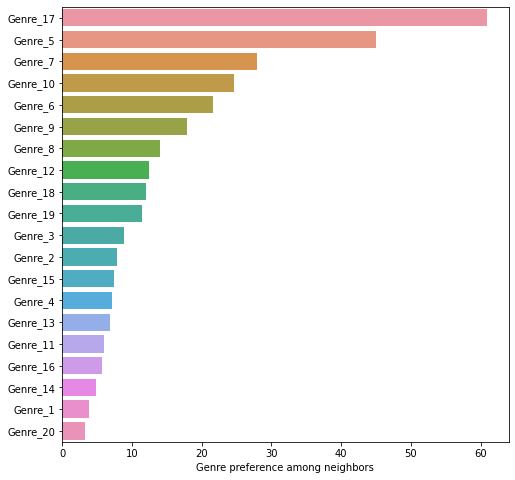

In [83]:
# Find top genres
fig, ax = plt.subplots(figsize=(8,8))
genre_ranking = pd.DataFrame(neighbor_user_ratings.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
sns.barplot(
    data=genre_ranking,
    y=genre_ranking.index,
    x=0
)
plt.xlabel("Genre preference among neighbors")
plt.show()

In [84]:
# Loop through genres in descending relevance order and print top 5 recs
for genre in genre_ranking.index[0:10]:
    
    g = float(genre[6:])
    highest_rated_recs_genre = neighbor_user_ratings.query("main_genre == @g")\
        .groupby(["title", "avg_rating", "ratings_count", "year"])["book_id"]\
        .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)\
        .rename(columns={"book_id":"percent_similar_users_read"})

    highest_rated_recs_genre["percent_similar_users_read"] = highest_rated_recs_genre["percent_similar_users_read"] / n_neighbors
    highest_rated_recs_genre = highest_rated_recs_genre.query("ratings_count > 400")

    print(genre)
    display(highest_rated_recs_genre[["title", "avg_rating", "ratings_count"]].head(10))
    print("_____\n")

Genre_17


,title,avg_rating,ratings_count
21,"Kings of the Wyld (The Band, #1)",4.42,2285.0
4,"Berserk, Vol. 1 (Berserk, #1)",4.38,10778.0
20,Judas Unchained,4.30,21306.0
68,"Thrawn (Star Wars: Thrawn, #1)",4.30,5220.0
25,Lost Stars,4.25,9512.0
0,A Good Man is Hard to Find and Other Stories,4.24,26384.0
22,"Lion of Macedon (Greek Series, #1)",4.24,3375.0
33,Pandora's Star,4.24,28964.0
55,The Dreaming Void,4.18,16512.0
60,"The Long Way to a Small, Angry Planet (Wayfare...",4.18,703.0


_____

Genre_5


,title,avg_rating,ratings_count
22,Our Revolution: A Future to Believe In,4.29,2430.0
7,"Creativity, Inc.: Overcoming the Unseen Forces...",4.24,27705.0
14,Falling Upward: A Spirituality for the Two Hal...,4.24,4884.0
34,The Hero With a Thousand Faces,4.24,18378.0
2,Becoming Wise: An Inquiry into the Mystery and...,4.22,1683.0
12,"Desiring the Kingdom: Worship, Worldview, and ...",4.22,1659.0
5,"Boundaries: When to Say Yes, How to Say No to ...",4.19,13041.0
11,Deep Work: Rules for Focused Success in a Dist...,4.19,15605.0
1,"After the Ecstasy, the Laundry: How the Heart ...",4.16,3187.0
42,"The Vital Question: Energy, Evolution, and the...",4.14,843.0


_____

Genre_7


,title,avg_rating,ratings_count
18,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,95353.0
11,"Killer of Men (Long War, #1)",4.27,1176.0
23,The World of Ice & Fire: The Untold History of...,4.26,12952.0
12,Man-Eaters of Kumaon,4.25,2609.0
4,Atlas of Remote Islands,4.24,1807.0
16,"Saga, Vol. 1 (Saga, #1)",4.24,142640.0
3,An Era of Darkness: The British Empire in India,4.23,875.0
26,"Tin Stars (Descender, #1)",4.12,7746.0
21,The Story of B: An Adventure of the Mind and S...,4.11,7822.0
25,Thousandth Night,4.10,434.0


_____

Genre_10


,title,avg_rating,ratings_count
9,"Senlin Ascends (The Books of Babel, #1)",4.37,1410.0
8,Michael Moorcock's Elric of Melnibone,4.32,1137.0
3,Bridge of Birds (The Chronicles of Master Li a...,4.30,8063.0
0,"Age of Myth (The Legends of the First Empire, #1)",4.27,9328.0
12,The False Prince (The Ascendance Trilogy #1),4.23,51292.0
2,"American Gods (American Gods, #1)",4.11,1647.0
14,The Golem and the Jinni (The Golem and the Jin...,4.10,61387.0
6,Down Town (The Dresden Files Graphic Novels),4.02,651.0
1,"Air Awakens (Air Awakens, #1)",4.01,9408.0
11,The Devil in the White City,3.99,24118.0


_____

Genre_6


,title,avg_rating,ratings_count
13,The Complete Works of H.P. Lovecraft,4.34,9733.0
12,The Circular Ruins,4.30,409.0
0,2016 on Goodreads,4.25,1167.0
7,Patriotism,4.12,1869.0
10,Superman: Birthright,4.12,9365.0
11,The Blind Owl,3.99,5325.0
14,The Gunslinger,3.98,346978.0
5,Killing and Dying: Stories,3.97,4309.0
6,Layla and Majnun,3.94,1205.0
9,Rogues,3.86,10516.0


_____

Genre_9


,title,avg_rating,ratings_count
13,The 50th Law,4.13,4254.0
16,The Rest Is Noise: Listening to the Twentieth ...,4.08,9607.0
3,If the Oceans Were Ink: An Unlikely Friendship...,4.02,792.0
15,"The Power of Broke: How Empty Pockets, a Tight...",4.00,844.0
9,"Reckless Endangerment: How Outsized Ambition, ...",3.93,1121.0
2,Have Space Suit—Will Travel,3.89,20603.0
1,Fool's Gold,3.82,2076.0
4,In Real Life,3.80,17433.0
12,Tesla: Man Out of Time,3.79,2818.0
5,Inside Apple,3.78,4329.0


_____

Genre_8


,title,avg_rating,ratings_count
2,Asterios Polyp,4.19,20053.0
8,The Course of Love,4.01,7488.0
6,So Big,4.00,5949.0
5,Mischling,3.89,6639.0
1,All the Names,3.88,9681.0
4,Honor Girl: A Graphic Memoir,3.83,4486.0
10,The Devourers,3.74,1170.0
9,The Devil In Pew Number Seven,3.70,3640.0
12,Whiskey Tango Foxtrot,3.51,4305.0
0,A Small Revolution,3.26,1287.0


_____

Genre_12


,title,avg_rating,ratings_count
9,"The Walking Dead, Compendium 1",4.43,58434.0
4,Outland,4.14,786.0
11,"Watership Down (Watership Down, #1)",4.06,297140.0
5,The Fisherman,4.01,1458.0
6,"The Forge of God (Forge of God, #1)",3.86,10215.0
1,Dreamsnake,3.85,6782.0
8,The Train Was on Time,3.84,952.0
7,"The Lost Gate (Mither Mages, #1)",3.82,18675.0
0,City of Illusions,3.81,2872.0
10,Walkaway: A Novel,3.80,1543.0


_____

Genre_18


,title,avg_rating,ratings_count
1,"Gateway (Heechee Saga, #1)",4.07,30282.0
5,"Spin (Spin, #1)",4.01,26520.0
6,The Cobra Event,4.00,556.0
7,"The Forgetting (The Forgetting, #1)",3.98,4547.0
8,The Good House,3.93,1908.0
3,Miss Peregrine's Home For Peculiar Children (M...,3.89,25355.0
0,"Anomaly (Schrodinger's Consortium, #1)",3.75,977.0
2,Look at Me,3.40,8290.0
4,Pride and Prejudice and Zombies (Pride and Pre...,3.28,105537.0
9,Universal Harvester,3.27,5863.0


_____

Genre_19


,title,avg_rating,ratings_count
4,Homicide: A Year on the Killing Streets,4.37,10487.0
8,"Working Stiff: Two Years, 262 Bodies, and the ...",4.11,8101.0
7,"UNSUB (UNSUB, #1)",4.03,1314.0
1,"American Fire: Love, Arson, and Life in a Vani...",3.79,3397.0
5,Normal,3.70,1850.0
2,Company Town,3.55,2365.0


_____



### Using Matrix Factorization

In [85]:
# Find larger number of similar users than before
large_neighborhood_ratings, target_user_ratings = find_neighbors(1000, target_user, df_reviews, book_index, df_books)

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_62901/1194291868.py:56: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_62901/1194291868.py:57: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]


In [86]:
# Get unique users and books to slice df_reviews
neighbor_index = large_neighborhood_ratings["uid"].unique()
neighbor_index = np.append(neighbor_index, target_user)
neighbor_book_index = large_neighborhood_ratings["book_index"].unique()
neighbor_book_index = np.append(neighbor_book_index, target_user_ratings["book_index"].unique())

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, neighbor_book_index]
R = R[neighbor_index, :]

In [87]:
# Decompose user ratings matrix R
U, sigma, Vt = svds(R, k = 5)
sigma = np.diag(sigma)

U = sparse.csr_matrix(U)
sigma = sparse.csr_matrix(sigma)
Vt = sparse.csr_matrix(Vt)

# Get predictions
dot_1 = U.dot(sigma)
all_user_predicted_ratings = dot_1 @ Vt
df_preds = pd.DataFrame(all_user_predicted_ratings.toarray(), columns=neighbor_book_index, index=neighbor_index).reset_index()

In [154]:
# Get target user's top predicted ratings
target_pred_books = df_preds[df_preds["index"] == target_user].columns[1:]
target_pred_ratings = df_preds[df_preds["index"] == target_user].values[0][1:]

top_preds = pd.DataFrame({"book_index":target_pred_books, "predicted_rating":target_pred_ratings})\
                .sort_values(by="predicted_rating", ascending=False)\
                .merge(book_index.reset_index(), left_on="book_index", right_on="index")\
                .merge(df_books[["book_id", "title", "avg_rating", "ratings_count", "year", "main_genre"]], on="book_id")\
                .drop(columns=["index", "book_id"])

# Filter out already read books
top_preds = top_preds[~top_preds["book_index"].isin(target_user_books)]
top_preds.drop(["book_index"], axis=1, inplace=True)
top_preds.head()

,predicted_rating,title,avg_rating,ratings_count,year,main_genre
6,0.021828,Freakonomics: A Rogue Economist Explores the H...,3.94,529274.0,2006,5.0
7,0.016555,The Magicians (The Magicians #1),3.48,152315.0,2009,10.0
8,0.014438,A Death in Italy: The Definitive Account of th...,3.71,284.0,2009,9.0
9,0.014246,Ninefox Gambit (The Machineries of Empire #1),3.91,3425.0,2016,17.0
10,0.014007,"A Midwife's Tale: The Life of Martha Ballard, ...",4.00,4481.0,1991,9.0


In [156]:
# Loop through genres in descending relevance order and print top 5 recs
for genre in genre_ranking.index[0:10]:
    
    g = float(genre[6:])
    highest_rated_pred_genre = top_preds.query("main_genre == @g")\
        .sort_values(by="predicted_rating", ascending=False)\
        .query("ratings_count > 400")\


    print(genre)
    display(highest_rated_pred_genre[["title", "avg_rating", "ratings_count"]].iloc[0:10,:])
    print("_____\n")

Genre_17


,title,avg_rating,ratings_count
9,Ninefox Gambit (The Machineries of Empire #1),3.91,3425.0
21,"Steelheart (The Reckoners, #1)",4.16,79287.0
24,"Angels & Demons (Robert Langdon, #1)",3.86,2046499.0
33,Midnight Robber,3.89,1589.0
40,Pandora's Star,4.24,28964.0
55,Judas Unchained,4.30,21306.0
67,"Ringworld (Ringworld, #1)",3.96,78483.0
78,"The Quantum Thief (Jean le Flambeur, #1)",3.84,11406.0
88,"Red Sister (Book of the Ancestor, #1)",4.32,5784.0
90,Catalyst: A Rogue One Novel,3.73,6398.0


_____

Genre_5


,title,avg_rating,ratings_count
6,Freakonomics: A Rogue Economist Explores the H...,3.94,529274.0
11,The Metaphysical Club,4.07,2982.0
13,Black Holes and Baby Universes,4.09,9704.0
14,"Creativity, Inc.: Overcoming the Unseen Forces...",4.24,27705.0
31,"Jesus, Interrupted: Revealing the Hidden Contr...",3.93,5949.0
41,Guns,4.17,3687.0
53,"Rich Dad, Poor Dad",3.96,164543.0
54,The Lean Startup: How Today's Entrepreneurs Us...,4.04,95622.0
66,"Go Down, Moses",3.93,7562.0
72,God: The Failed Hypothesis: How Science Shows ...,3.90,6240.0


_____

Genre_7


,title,avg_rating,ratings_count
12,"I, Robot (Robot #0.1)",4.17,201196.0
16,Aurora,3.72,10174.0
20,I Am Malala: The Story of the Girl Who Stood U...,4.07,228884.0
43,"Perdido Street Station (Bas-Lag, #1)",3.96,41866.0
49,Y: The Last Man - The Deluxe Edition Book One,4.36,10549.0
60,"Saga, Vol. 1 (Saga, #1)",4.24,142640.0
68,Em and The Big Hoom,4.07,2282.0
101,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,95353.0
135,Scheisshaus Luck: Surviving the Unspeakable in...,4.09,1049.0
141,"The Walking Dead, Vol. 04: The Heart's Desire",4.22,22078.0


_____

Genre_10


,title,avg_rating,ratings_count
7,The Magicians (The Magicians #1),3.48,152315.0
17,"His Dark Materials (His Dark Materials, #1-3)",4.25,926.0
19,The Golem and the Jinni (The Golem and the Jin...,4.10,61387.0
27,The Hundred Thousand Kingdoms (Inheritance Tri...,3.81,30194.0
30,Rebel Queen,4.03,5466.0
44,Wicked: The Life and Times of the Wicked Witch...,3.52,508863.0
45,"Age of Myth (The Legends of the First Empire, #1)",4.27,9328.0
69,Don Quixote,3.75,503.0
73,"Senlin Ascends (The Books of Babel, #1)",4.37,1410.0
75,"The Color of Magic (Discworld, #1; Rincewind #1)",3.98,195805.0


_____

Genre_6


,title,avg_rating,ratings_count
18,The Gunslinger,3.98,346978.0
34,The Sandman: Overture,3.95,53398.0
52,Worlds of Exile and Illusion: Rocannon's World...,4.15,1120.0
79,Octavia's Brood: Science Fiction Stories from ...,3.94,1088.0
113,Testaments Betrayed: An Essay in Nine Parts,4.03,1109.0
147,Come Close,3.93,705.0
166,"Pretty Deadly, Vol. 1: The Shrike",3.84,9218.0
170,The Kite Runner: Graphic Novel,4.25,6466.0
216,Play It as It Lays,3.86,18076.0
230,The Laugh of the Medusa,4.16,752.0


_____

Genre_9


,title,avg_rating,ratings_count
10,"A Midwife's Tale: The Life of Martha Ballard, ...",4.00,4481.0
38,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0
46,"The Innovators: How a Group of Hackers, Geniu...",4.04,15567.0
80,In Real Life,3.80,17433.0
92,Onward: How Starbucks Fought for Its Life with...,3.79,11574.0
133,Elizabeth the Queen: The Life of a Modern Monarch,3.85,20342.0
201,John McAfee's Last Stand,3.56,493.0
227,Assata: An Autobiography,4.47,11057.0
268,Hitch 22: A Memoir,4.03,406.0
283,"Infomocracy (The Centenal Cycle, #1)",3.55,1709.0


_____

Genre_8


,title,avg_rating,ratings_count
22,The Shell Collector,4.06,4771.0
25,Paris to the Moon,3.76,11222.0
51,"Moving Violations: War Zones, Wheelchairs, and...",4.07,434.0
71,A Book of American Martyrs,3.89,1225.0
74,Evicted: Poverty and Profit in the American City,4.47,18205.0
82,My Brilliant Friend (The Neapolitan Novels #1),3.89,66369.0
94,Night (The Night Trilogy #1),4.30,708754.0
99,The Velvet Hours,3.90,2537.0
134,The Woman on the Orient Express,4.15,2305.0
163,Beyond the Sky and the Earth: A Journey into B...,4.13,2641.0


_____

Genre_12


,title,avg_rating,ratings_count
84,"Three Men in a Boat (Three Men, #1)",3.90,31122.0
86,"Watership Down (Watership Down, #1)",4.06,297140.0
117,"The Walking Dead, Vol. 01: Days Gone Bye",4.29,168436.0
127,The Bear and the Nightingale (The Winternight ...,4.14,14404.0
148,The Undertaking of Lily Chen,3.45,2396.0
292,"NPCs (Spells, Swords, & Stealth, #1)",4.01,5206.0
325,Maus I: A Survivor's Tale: My Father Bleeds Hi...,4.35,189288.0
330,Wolves of the Calla,4.17,102274.0
416,"All the Pretty Horses (The Border Trilogy, #1)",3.97,70190.0
418,"The Girl of Hrusch Avenue (Powder Mage, #0.5)",3.94,1655.0


_____

Genre_18


,title,avg_rating,ratings_count
70,The Diary of Adam and Eve,3.96,7396.0
165,"Gateway (Heechee Saga, #1)",4.07,30282.0
252,The Good House,3.93,1908.0
300,"Spin (Spin, #1)",4.01,26520.0
327,"A Corner of White (The Colors of Madeleine, #1)",3.79,1234.0
404,Fool's Assassin (The Fitz and The Fool Trilogy...,4.36,5382.0
406,"Paper Girls, Vol. 1 (Paper Girls, #1)",3.86,28332.0
409,"Welcome to Night Vale (Night Vale, #1)",3.86,18935.0
439,The Dead Key,3.79,19462.0
478,Miramont's Ghost,3.34,14483.0


_____

Genre_19


,title,avg_rating,ratings_count
23,"Avatar: The Last Airbender: The Rift, Part 1 (...",4.33,10667.0
35,"Bruno, Chief of Police (Bruno, Chief of Police...",3.85,4662.0
61,Richard Stark's Parker: The Hunter,4.20,6014.0
106,"Bandette, Volume 1: Presto!",3.90,2342.0
185,Company Town,3.55,2365.0
192,The No. 1 Ladies' Detective Agency (No. 1 Lad...,3.76,183034.0
228,"The Various Haunts of Men (Simon Serrailler, #1)",3.81,7219.0
277,The X-Files: Cold Cases,3.70,862.0
298,Dogsbody,4.06,4849.0
328,Run,3.88,8209.0


_____

